<a href="https://colab.research.google.com/github/danielrocha92/machinelearning/blob/main/Neur%C3%B4nio%20artificial-Perceptrons.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importa todas as bibliotecas necessárias.
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
# converte os dados de dataset para tensor
transform = transforms.ToTensor()

In [ ]:
#definir a conversão de imagem para tensor

#carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [ ]:
#cria um buffer para pegar os dados por partes
#batch_size=64 para que os subgrupos sejam de 64 itens
#shuffle=true determina que os itens serão tomados de forma aleatória
#um mesmo item pode estar presente em mais de um subgrupo.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [ ]:
#carrega a parte de validação do dataset (similar trainset)
valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)

In [ ]:
#cria um buffer para pegar os dados por partes (similar trainset)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

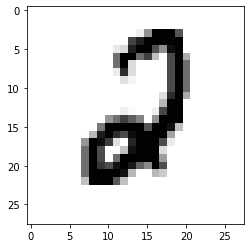

In [ ]:
#abrir um dos itens do dataset para ter uma ideia de seu formato
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
#ver as dimensões dos tensores imagens
#tensor imagem possui 3 dimensões
#1a dimensão é o número de canais da imagem.
#Imagens preto e branco possuem apenas um canal.
#Imagens coloridas costumam ter 3 canais (vermelho, azul e verde).
#As duas ultimas dimensões representam a quantidade de pixels, nesse caso 28 x 28 = 784 pixels.
print(imagens[0].shape)

torch.Size([1, 28, 28])


In [ ]:
#ver as dimensões dos tensores etiquetas
#tensor etiqueta não possui dimensão nenhuma por ser um escalar
print(etiquetas[0].shape)

torch.Size([])


In [ ]:
#Para o Pytorch, cada imagem é uma "matriz" (na verdade é um tensor) 28 x 28
#com valores para cada elemento variando de 0 a 1 de forma continua.
#imprimir um tensor como exemplo
print(imagens[0])
print(etiquetas[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0627, 0.4275,
          1.0000, 0.9922, 0.9922, 0.6667, 0.0000, 0.0000,

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        #camada de entrada, 784 neurônios que se ligam a 128
        self.linear1 = nn.Linear(28*28, 128)
        #camada interna 1, 128 neurônios que se ligam a 64
        self.linear2 = nn.Linear(128, 64)
        #camada interna 2, 64 neurônios que se ligam a 10
        self.linear3 = nn.Linear(64, 10)
        #para a camada de saída não é necessário definir nada
        #pois só precisamos pegar o output da camada interna 2
        
    def forward(self,X):
        #função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear1(X))
        #função de ativação da camada interna 1 para a camada interna 2
        X = F.relu(self.linear2(X))
        #função de ativação da camada interna 2 para a camada de saída
        X = self.linear3(X)
        # dado utilizado para calcular a perda
        return F.log_softmax(X, dim=1)

In [ ]:
def treino(modelo, trainloader, device):
    #define a polítca de atualização dos pesos e da bias
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    #timer para sabermos quanto tempo levou o treino
    inicio = time()
    #definindo o criterio para calcular a perda
    criterio = nn.NLLLoss()
    #número de epochs que o algoritmo rodará
    EPOCHS = 30
    #ativando o modo de treinamento do modelo
    modelo.train()
    j = 0
    for epoch in range(EPOCHS):
        #inicialização da perda acumulada da epoch em questão
        perda_acumulada = 0
        
        for imagens, etiquetas in trainloader:

            #convertendo as imagens para  "vetores" de 28*28 casas
            #para ficarem compatíveis com a camada de entrada
            imagens = imagens.view(imagens.shape[0], -1)
            #zerando os gradientes por conta do ciclo anterior
            otimizador.zero_grad()
            #colocando os dados no modelo
            output = modelo(imagens.to(device))
            #calculando a perda da epoch em questão
            perda_instantanea = criterio(output, etiquetas.to(device))
            # back propagation a partir da perda
            perda_instantanea.backward()
            #atualizando os pesos e a bias
            otimizador.step()
            #atualização da perda acumulada
            perda_acumulada += perda_instantanea.item()
 
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [ ]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens,etiquetas in valloader:
      for i in range(len(etiquetas)):
        img = imagens[i].view(1, 784)
        #desativar o gradiente para acelerar a validação.
        #Grafos computacionais dinâmicos tem um custo alto de processamento
        with torch.no_grad():
            #output do modelo em escala logaritmica
            logps = modelo(img.to(device))

        # converte output para escala normal(lembrando que é um tensor)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        # converte o tensor em um número, no caso, o número que o modelo previu como correto
        etiqueta_pred = probab.index(max(probab))
        etiqueta_certa = etiquetas.numpy()[i]
        #compara a previsão com o valor correto
        if(etiqueta_certa == etiqueta_pred):
            conta_corretas += 1
        conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [ ]:
def visualiza_pred(img, ps):

    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Palpite')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
#inicializa o modelo
modelo = Modelo()
# modelo rodará na GPU se possível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device) 

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
treino(modelo, trainloader, device)
validacao(modelo, valloader, device)


Epoch 1 - Perda resultante: 1.2008323200793662
Epoch 2 - Perda resultante: 0.38684460970320933
Epoch 3 - Perda resultante: 0.31256825856562614
Epoch 4 - Perda resultante: 0.2698947925573346
Epoch 5 - Perda resultante: 0.23843389116068767
Epoch 6 - Perda resultante: 0.21335119736204142
Epoch 7 - Perda resultante: 0.19355727179345292
Epoch 8 - Perda resultante: 0.17625274530240595
Epoch 9 - Perda resultante: 0.16163033346679292
Epoch 10 - Perda resultante: 0.1492799696589965
Epoch 11 - Perda resultante: 0.13808704003779046
Epoch 12 - Perda resultante: 0.12816373944711457
Epoch 13 - Perda resultante: 0.11939150305278202
Epoch 14 - Perda resultante: 0.11133743086353198
Epoch 15 - Perda resultante: 0.10413870443580056
Epoch 16 - Perda resultante: 0.09750003467645568
Epoch 17 - Perda resultante: 0.09184690589097136
Epoch 18 - Perda resultante: 0.08604971271480864
Epoch 19 - Perda resultante: 0.08138843789410743
Epoch 20 - Perda resultante: 0.0772857395683858
Epoch 21 - Perda resultante: 0.07

Número previsto = 7


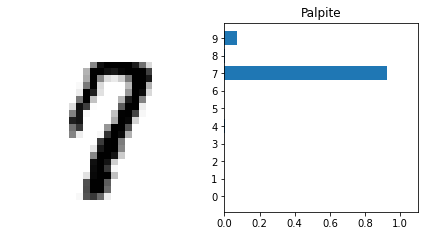

In [ ]:
imagens, etiquetas = next(iter(valloader))

img = imagens[0].view(1, 784)
with torch.no_grad():
    logps = modelo(img.to(device))

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Número previsto =", probab.index(max(probab)))
visualiza_pred(img.view(1, 28, 28), ps)

In [ ]:
#salvar o modelo
torch.save(modelo.state_dict(), './meu_modelo.pt')

#carregar o modelo
modelo_carregado = Modelo()

modelo_carregado.load_state_dict(torch.load('./meu_modelo.pt'))
modelo_carregado.eval()
modelo_carregado.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)